# Student Details
**Name: Muhammad Mubashar Mazhar**

**Student ID: 3763342**

# Part A. Static Visualization

1. First we access the required data of “Daily Climate Observations” from GeoMET API (https://ecccmsc.github.io/opendata/msc-geomet/readme_en/).

2. Then we will extract data, using the OWSLIB using Jupyter Notebook for the closest observation station to '560 Rochester St, Ottawa, ON, CA' for the entirety of 2011.

## Install and import libraries

First we will install and import the libraries

In [1]:
# installing libraries
!pip install OWSLib geopy
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 32.9 MB/s eta 0:00:00


In [9]:
from datetime import date
import json
import math
from textwrap import fill
import folium
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from matplotlib import pyplot as plt, dates as mdates
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd
from tabulate import tabulate
# Connect to the GeoMET API to fetch climate stations within the specified region
from owslib.wfs import WebFeatureService
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

## Getting Canada Information

We use the Canadian Weather API to retrieve active climate stations located within a defined buffer zone around the latitude and longitude coordinates of 560 Rochester St.

In [3]:
def get_info(latitude, longitude, buffer_distance, projection):
  """
  Function to return climate stations information
  """
  # Define bounding box based on the buffer
  bounding_box = [
      longitude - buffer_distance * 0.014,
      latitude - buffer_distance * 0.009,
      longitude + buffer_distance * 0.014,
      latitude + buffer_distance * 0.009,
  ]

  climate_api = Features("https://api.weather.gc.ca/")
  climate_stations = climate_api.collection_items(
      "climate-stations", bbox=bounding_box, STATUS_EN="Active"
  )

  # Check for station data and extract features
  if "features" in climate_stations:
      station_info = json.dumps(climate_stations, indent=4)
  else:
      raise ValueError("No active climate stations found. Verify the coordinates and try again.")

  return station_info

lat = 45.3986873
long = -75.7060998
buffer = 100
projection = 3347

station_info = get_info(lat, long, buffer, projection)

Now we perform following:
1. Use OGR to manage and open the climate station data source in GeoJSON format.
2. Transform the coordinates of the specified location (latitude and longitude) and create a buffer around the given coordinates to define a search radius.
3. Identify the climate stations located within the specified buffer distance from the given location.
4. Query the Canadian Weather API for data on the closest active climate station within the buffer zone.
5. Extract and display the name and ID of the closest active climate station.

In [12]:
# Open the GeoJSON file using OGR driver
driver = ogr.GetDriverByName("GeoJSON")  # Get the GeoJSON driver
data_source = driver.Open(station_info)  # Open the station_info file, which is expected to be a GeoJSON
layer = data_source.GetLayer()  # Get the layer from the GeoJSON file (it contains geometries)

# Extract the spatial reference system (SRS) of the input data
SRS_input = layer.GetSpatialRef()  # Get the spatial reference of the layer (input SRS)

# Create a spatial reference object using the input SRS (this is for working with projections)
SR = osr.SpatialReference(str(SRS_input))  # Create an osr SpatialReference object from the SRS input
epsg = SR.GetAuthorityCode(None)  # Get the EPSG code for the input SRS (the authority code)

# Ensure that the SRS input is in EPSG format
SRS_input.ImportFromEPSG(int(epsg))  # Set the SRS input's EPSG code explicitly

# Create a new spatial reference object for the target (projected) SRS
SRS_projected = osr.SpatialReference()  # Create a new empty spatial reference object
SRS_projected.ImportFromEPSG(projection)  # Import the EPSG code for the desired projection (this code must be provided)

# Return a coordinate transformation object to convert between input and projected SRS
transform = osr.CoordinateTransformation(SRS_input, SRS_projected)


point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 10)  # Set the buffer to minimum so we can get only one closest station

stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STN_ID)                 #getting station id inside buffer
        station_latitude = round(feature.LATITUDE / 10**7, 2)
        station_longitude = round(feature.LONGITUDE / 10**7, 2)
if not stations:
    raise ValueError(
        f"There are no climate stations within {buffer} km"
        + " of the chosen coordinates. Please verify the coordinates."
    )
print(f"stations:{stations}, station latitude:{station_latitude} , station longitude:{station_longitude}")

oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items("climate-stations", STN_ID=stations[0], STATUS_EN="Active")
closest_station = station_data['features']

closest_station_name = closest_station[0]['properties']['STATION_NAME'] #getting station id and name
closest_station_id = closest_station[0]['properties']['STN_ID']
print(f"Closest Climate Station: {closest_station_name}, closest station id: {closest_station_id}")

stations:[4327], station latitude:45.24 , station longitude:-75.43
Closest Climate Station: OTTAWA, closest station id: 4327


## Fetching and Filtering Climate Daily Data from the Canadian Weather API
1. Set up a mechanism to interact with the Canadian weather API to fetch climate daily data based on a specified climate station name.
2. Establish the request structure to retrieve data in chunks, with a maximum of 2,000,000 records per request.
3. Retrieve climate data in multiple chunks to accommodate the record limit and append each chunk of data into a list to accumulate all the records for further processing.
4. After all the data is fetched, filter the collected data to extract records specifically from the year 2011.
5. Store the filtered data in a separate list for easier access and analysis, ensuring it is ready for further processing.


In [5]:
base_url = "https://api.weather.gc.ca/collections/climate-daily/items"

params = {
    "STATION_NAME": closest_station_name,
    "limit": 2000000
}

def get_properties(base_url, params):
  all_data = []

  while True:
      response = requests.get(base_url, params=params) #accumulating data as there was pagination in the api
      if response.status_code == 200:
          data = response.json()
          all_data.extend(data['features'])
          if 'next' in data['links']:
              next_url = data['links']['next']['href']
              base_url = next_url
          else:
              break
      else:
          print(f"Failed to retrieve data. Status code: {response.status_code}")
          break

  properties_list = [feature['properties'] for feature in all_data if feature['properties'].get('LOCAL_YEAR') == 2011] #filtering based on year
  return properties_list

properties_list = get_properties(base_url, params)

## Q1: Create individual plots for minimum, mean and maximum temperature, and a 4th plot of all temperatures in one plot using the subplot function and aligning the axes.

Now, we will plot the temperature where the date will be on x-axis and temperature on y-axis

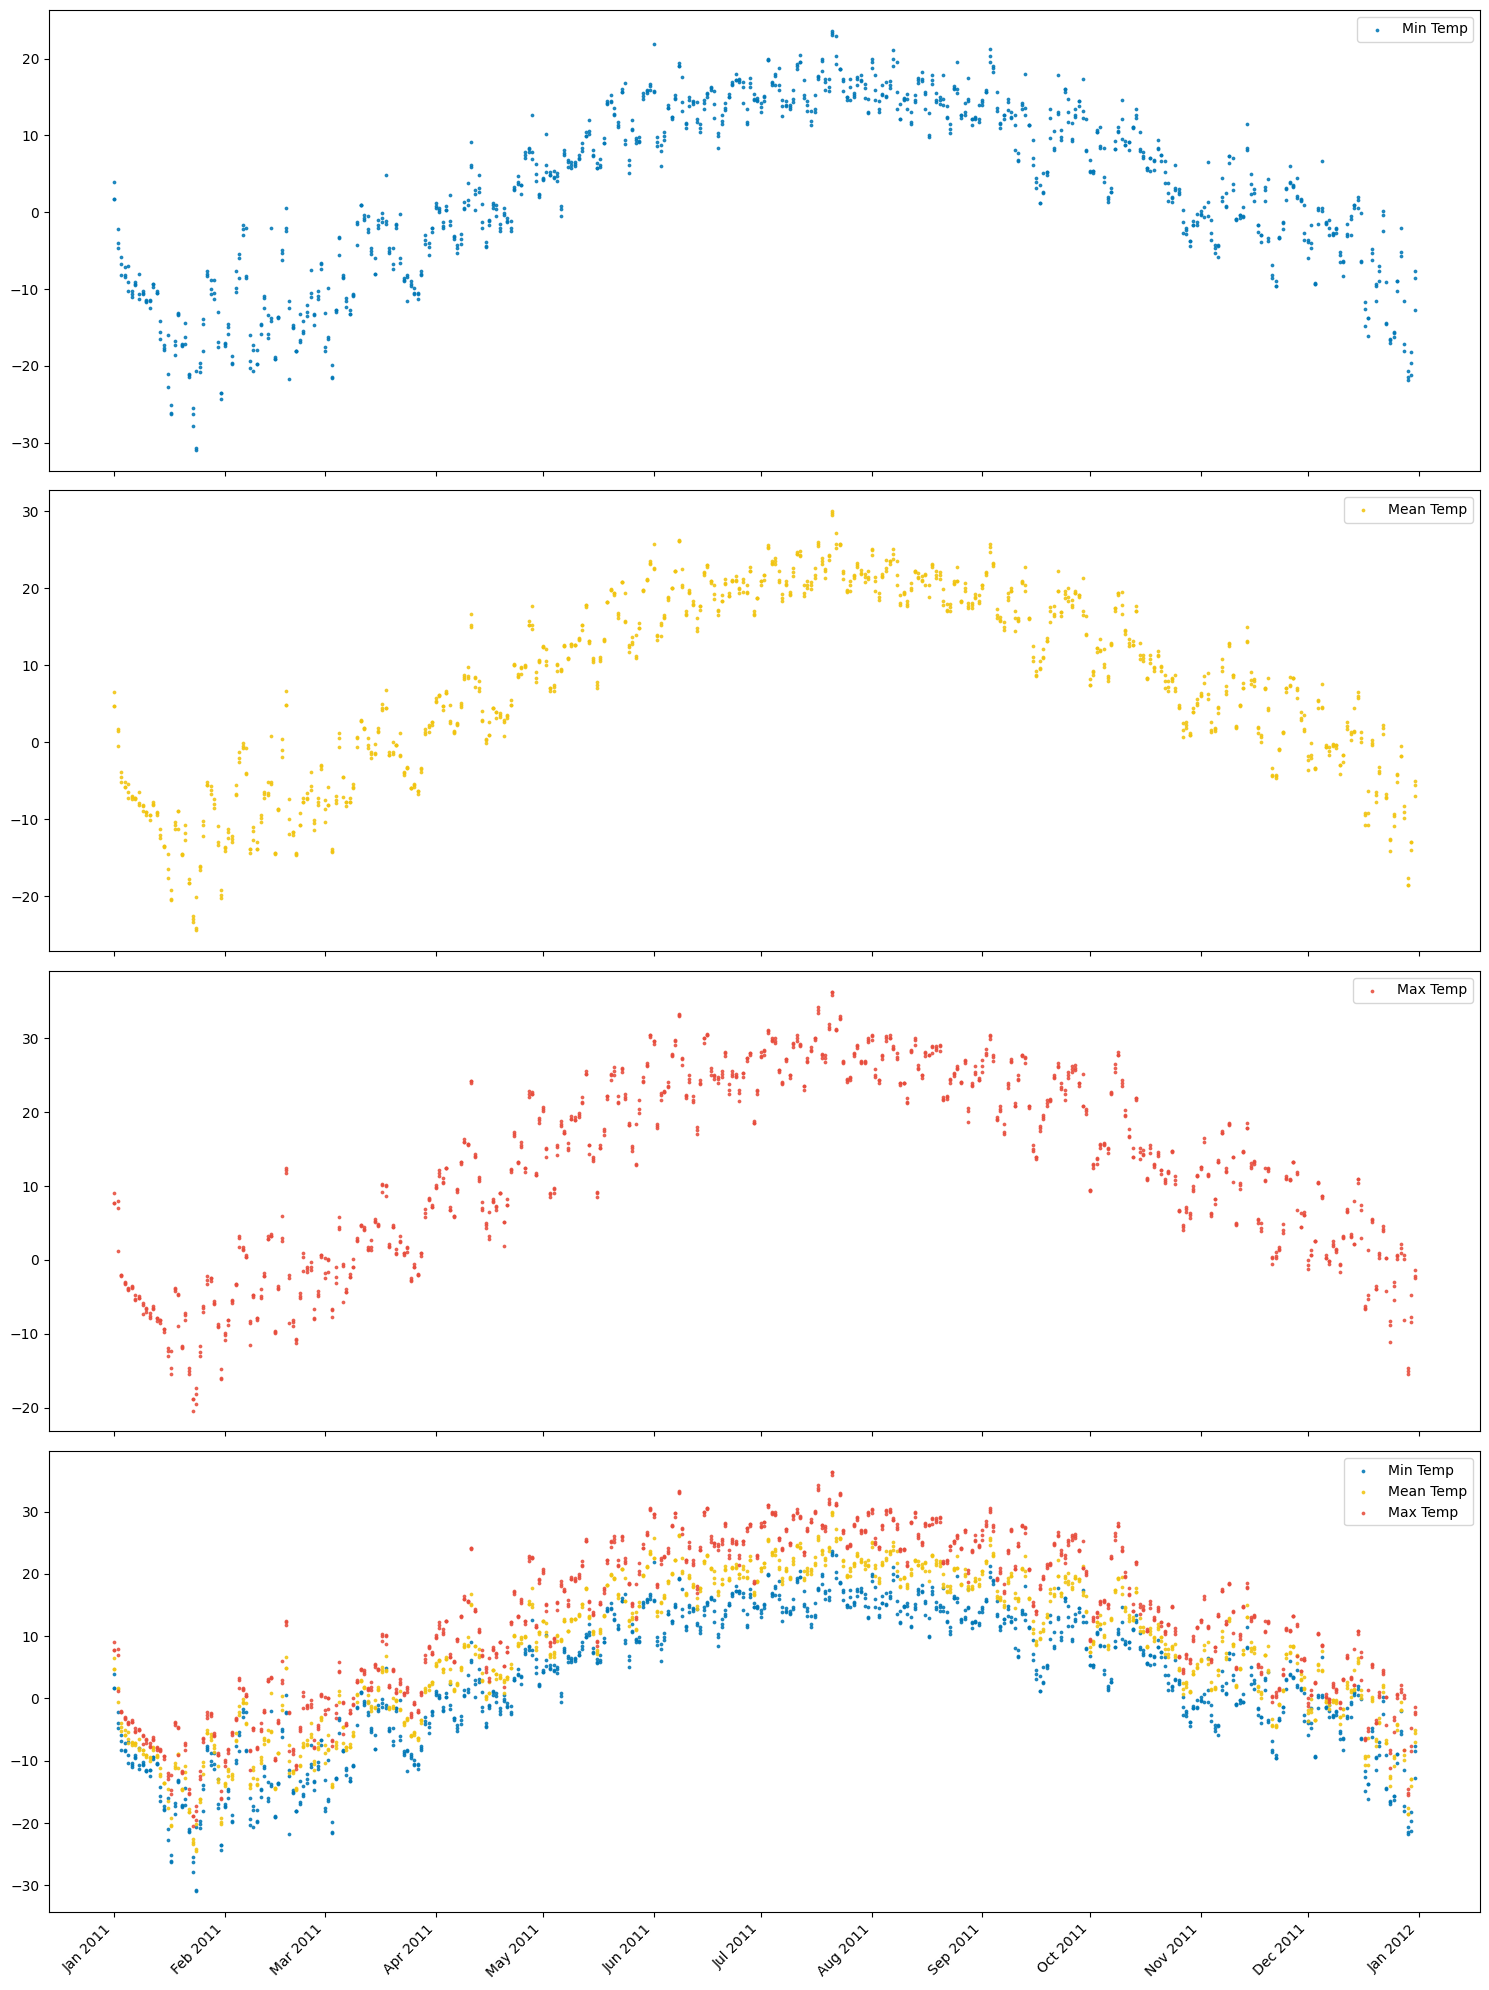

In [6]:
# Convert date strings to datetime objects
dates = [datetime.strptime(entry['LOCAL_DATE'], '%Y-%m-%d %H:%M:%S') for entry in properties_list]

# Extract temperature data into separate lists
low_temps = [entry['MIN_TEMPERATURE'] for entry in properties_list]
average_temps = [entry['MEAN_TEMPERATURE'] for entry in properties_list]
high_temps = [entry['MAX_TEMPERATURE'] for entry in properties_list]

# Set up a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

# Set marker size and transparency
marker_size = 3
alpha_value = 0.8  # Increased intensity by reducing transparency

# Plot data for Min, Mean, and Max temperatures in the first 3 subplots with new colors
axes[0].scatter(dates, low_temps, s=marker_size, alpha=alpha_value, label='Min Temp', color='#0077B6')  # Intense blue
axes[1].scatter(dates, average_temps, s=marker_size, alpha=alpha_value, label='Mean Temp', color='#F1C40F')  # Bright yellow
axes[2].scatter(dates, high_temps, s=marker_size, alpha=alpha_value, label='Max Temp', color='#E74C3C')  # Vivid red

# Plot all temperatures in the fourth subplot for comparison
axes[3].scatter(dates, low_temps, s=marker_size, alpha=alpha_value, label='Min Temp', color='#0077B6')
axes[3].scatter(dates, average_temps, s=marker_size, alpha=alpha_value, label='Mean Temp', color='#F1C40F')
axes[3].scatter(dates, high_temps, s=marker_size, alpha=alpha_value, label='Max Temp', color='#E74C3C')

# Add legends to each subplot
for ax in axes:
    ax.legend()

# Format the x-axis for all subplots (monthly ticks and date format)
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Remove gridlines for a cleaner look
for ax in axes:
    ax.grid(False)

# Rotate x-axis labels in the last subplot
plt.setp(axes[3].get_xticklabels(), rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

## Q2: Plot the cumulative precipitation over the year.

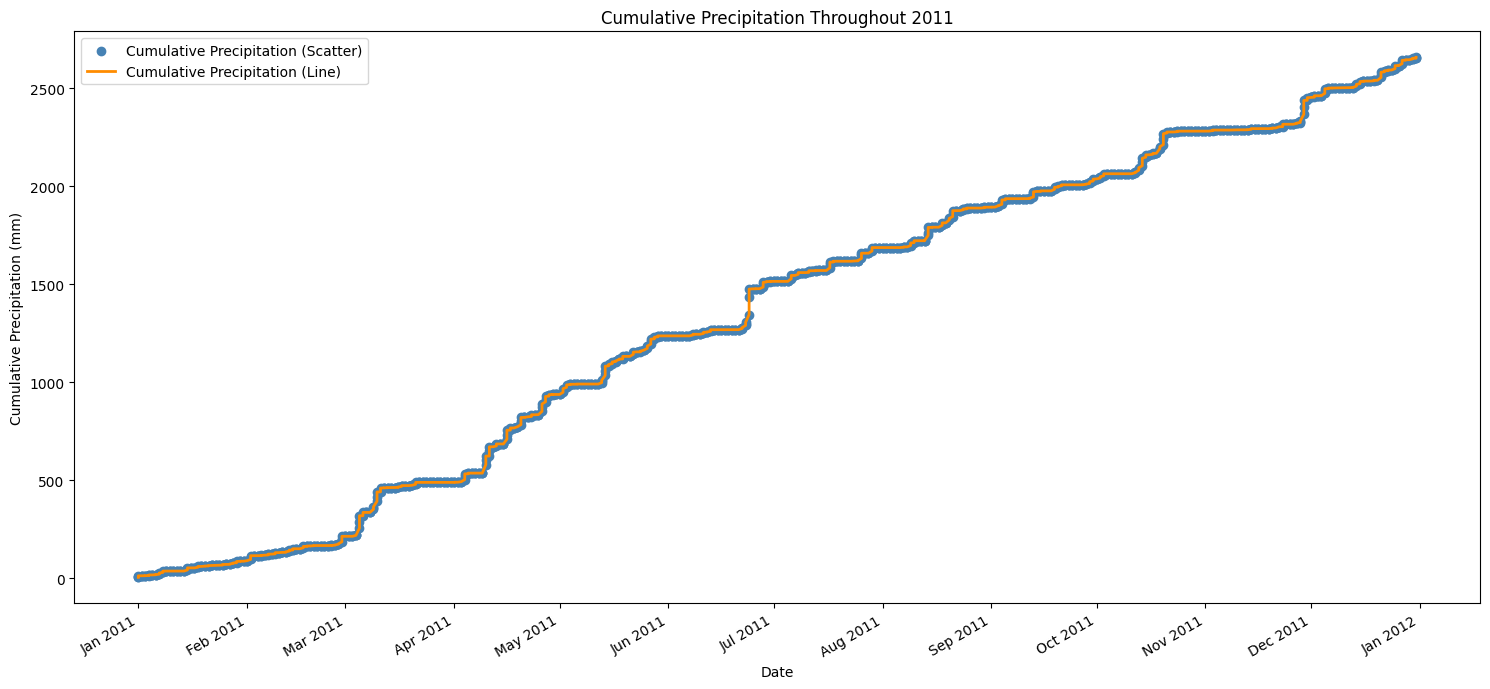

In [14]:
# Sort the data by date to ensure chronological order
properties_list.sort(key=lambda x: datetime.strptime(x['LOCAL_DATE'], '%Y-%m-%d %H:%M:%S'))

# Extract date and precipitation values, replacing None with 0 for precipitation
dates = [datetime.strptime(item['LOCAL_DATE'], '%Y-%m-%d %H:%M:%S') for item in properties_list]
precipitation_values = [item['TOTAL_PRECIPITATION'] if item['TOTAL_PRECIPITATION'] else 0 for item in properties_list]

# Compute cumulative precipitation
cumulative_precip = np.cumsum(precipitation_values)

# Set up the figure and plot the data
plt.figure(figsize=(15, 7))

# Scatter plot for cumulative precipitation
plt.scatter(dates, cumulative_precip, label='Cumulative Precipitation (Scatter)', color='steelblue')

# Line plot for cumulative precipitation
plt.plot(dates, cumulative_precip, label='Cumulative Precipitation (Line)', color='darkorange', linewidth=2)

# Format x-axis for monthly ticks and labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Cumulative Precipitation (mm)')
plt.title('Cumulative Precipitation Throughout 2011')
plt.legend()

# Automatically format x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Display the plot
plt.show()


## Q3: 3. Create a geographic map – plot the location of the closest observation station in a folium map using a custom marker with a pop up that provide some details of the station (e.g.: Station Name, Station Number, and Latitude, Longitude) and a different style marker at the address provided.

We will utilize Folium to create an interactive map. The location of the climate station is marked with a blue icon, displaying its name, identification number, and geographic coordinates. Moreover, a red icon is used to highlight the location of 560 Rochester St, Ottawa, ON, Canada, providing clear visual context. We do it by applying following steps:
1. **Retrieve Station Data:** Extract the name, identifier, latitude, and longitude details of the weather or climate monitoring station to be plotted on the map.
2. **Retrieve Address Coordinates:** Collect the latitude and longitude values corresponding to a specific address or location of interest.
3. **Initialize the Map:** Create a map centered around the station's geographical coordinates, setting an appropriate zoom level to provide context for the surrounding area.
4. **Add a Station Marker:** Place a marker on the map to indicate the location of the station. Include a popup to display relevant station details such as its name, identifier, and precise coordinates. Use a distinct icon and color to differentiate it.
5. **Add an Address Marker:** Place another marker to indicate the address location. Use a different color and icon to distinguish it visually from the station marker.
6. **Display the Map:** Render the map with both markers for easy visualization of the spatial relationship between the station and the address.

In [17]:
import folium

station_name = properties_list[0]['STATION_NAME']
station_number = properties_list[0]['CLIMATE_IDENTIFIER'] #getting station data for map
latitude = station_latitude
longitude = station_longitude

address_latitude = lat
address_longitude = long

map_object = folium.Map(location=[latitude, longitude], zoom_start=11)


# Add a marker for the station
folium.Marker(
    location=[station_latitude, station_longitude],
    popup=(
        f"Station Name: {station_name}<br>"
        f"Station Number: {station_number}<br>"
        f"Coordinates: {station_latitude}, {station_longitude}"
    ),
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(map_object)

# Add a marker for the address
folium.Marker(
    location=[address_latitude, address_longitude],
    popup="Address Location",
    icon=folium.Icon(color='red', icon='home')
).add_to(map_object)

# Display the map
display(map_object)

# Part B

Now, we will calculate the boundaries of given time i.e. Spring: March 20th
Summer: June 21st, Autumn/Fall: Sept 23, and Winter: Dec 21th. We will also create the function to plot the changes.

We will follow following steps for season filtering data:

1. **Define Seasonal Parameters:** Establish the start and end dates for the specific season by combining the given year with the month and day inputs.

2. **Convert Dates to Comparable Format:** Transform the start and end dates into a consistent date format for comparison purposes.

3. **Check for Cross-Year Range:** Determine if the season spans across two calendar years (e.g., starting in December and ending in January).

4. **Filter Data for Cross-Year Range:** If the season crosses two years, include data where the date falls either after the start date or before the end date.

5. **Filter Data for Single-Year Range:** If the season is within a single year, include data where the date falls between the start and end dates.

6. **Return Filtered Results:** Provide the subset of data that matches the seasonal range criteria.

In [18]:
def filter_season_data(data, start_month_day, end_month_day, year):  # Function to filter data for a given season and year
    start_date = datetime.strptime(f"{year}-{start_month_day}", '%Y-%m-%d')
    end_date = datetime.strptime(f"{year}-{end_month_day}", '%Y-%m-%d')
    if start_date > end_date:
        return [d for d in data if datetime.strptime(d['LOCAL_DATE'], '%Y-%m-%d %H:%M:%S').date() >= start_date.date() or
                datetime.strptime(d['LOCAL_DATE'], '%Y-%m-%d %H:%M:%S').date() <= end_date.date()]
    else:
        return [d for d in data if start_date.date() <= datetime.strptime(d['LOCAL_DATE'], '%Y-%m-%d %H:%M:%S').date() <= end_date.date()]

We will follow following steps for temperature variation plotting:

1. **Filter Data for Valid Temperatures:** Extract only the records where the mean temperature is available (not null or missing).

2. **Extract Dates and Temperatures:** Parse the dates and retrieve the corresponding mean temperature values from the filtered data.

3. **Calculate Average Temperature:** Compute the average of the mean temperatures if the dataset is not empty. Handle cases where no valid temperature data is available.

4. **Set Up the Plot:** Initialize a figure with appropriate size to display temperature variation.

5. **Plot Mean Temperature:** Use a line plot with markers to depict the variation of mean temperature over the season's dates.

6. **Highlight the Average Temperature:** Add a horizontal dashed line to indicate the average temperature, annotated with its value.

7. **Customize Plot Appearance:**
   - Add a title that specifies the season.
   - Label the x-axis with dates and the y-axis with mean temperature values.
   - Format the x-axis to display dates in a month-day format for clarity.
   - Add a legend and enable a grid for better readability.

8. **Optimize Layout:** Adjust the layout to ensure all elements, such as labels and titles, are displayed without overlapping.

9. **Display the Plot:** Render the graph to visualize the temperature variation for the specified season.

In [23]:
def plot_season_temperature_variation(season_data, season_name):
    """
    Function to plot the variation of mean temperature for a given season.
    """
    # Filter out data with missing mean temperature values
    filtered_data = [prop for prop in season_data if prop['MEAN_TEMPERATURE'] is not None]
    dates = [datetime.strptime(prop['LOCAL_DATE'], '%Y-%m-%d %H:%M:%S') for prop in filtered_data]
    mean_temps = [prop['MEAN_TEMPERATURE'] for prop in filtered_data]

    # Calculate average temperature if data is available
    average_temp = sum(mean_temps) / len(mean_temps) if mean_temps else None

    # Set up the figure for plotting
    plt.figure(figsize=(12, 6))

    # Line plot for mean temperature with improved color
    plt.plot(dates, mean_temps, label='Mean Temperature', color='mediumseagreen', marker='o', linestyle='-', linewidth=2)

    # Add a horizontal line for the average temperature, if applicable
    if average_temp is not None:
        plt.axhline(y=average_temp, color='darkorange', linestyle='--', label=f'Average: {average_temp:.2f}°C')

    # Customize the plot with titles and labels
    plt.title(f'Mean Temperature Variation in {season_name}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Temperature (°C)', fontsize=14)

    # Add a legend and grid for clarity
    plt.legend(fontsize=12)
    plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

    # Format the x-axis for improved readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.gcf().autofmt_xdate()  # Rotate dates for better visibility

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Display the plot
    plt.show()


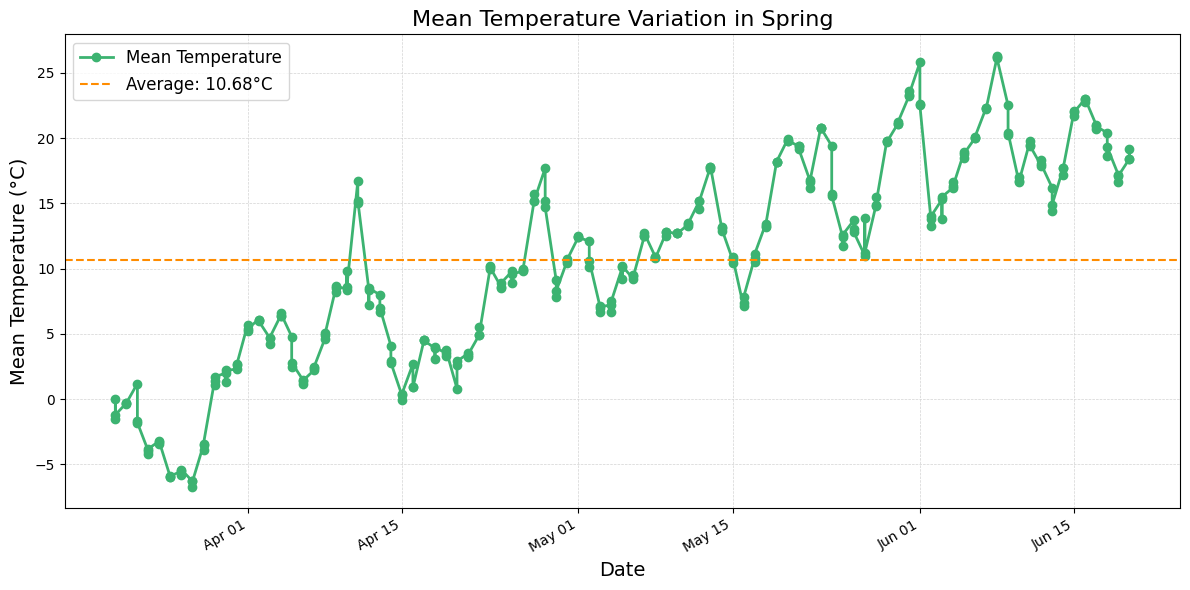

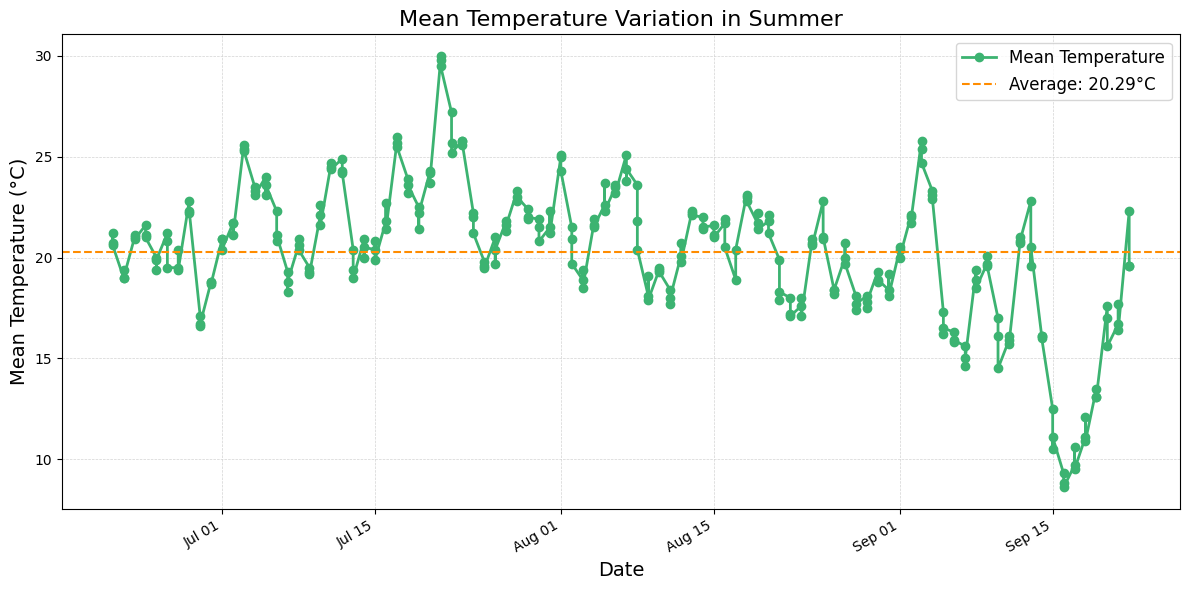

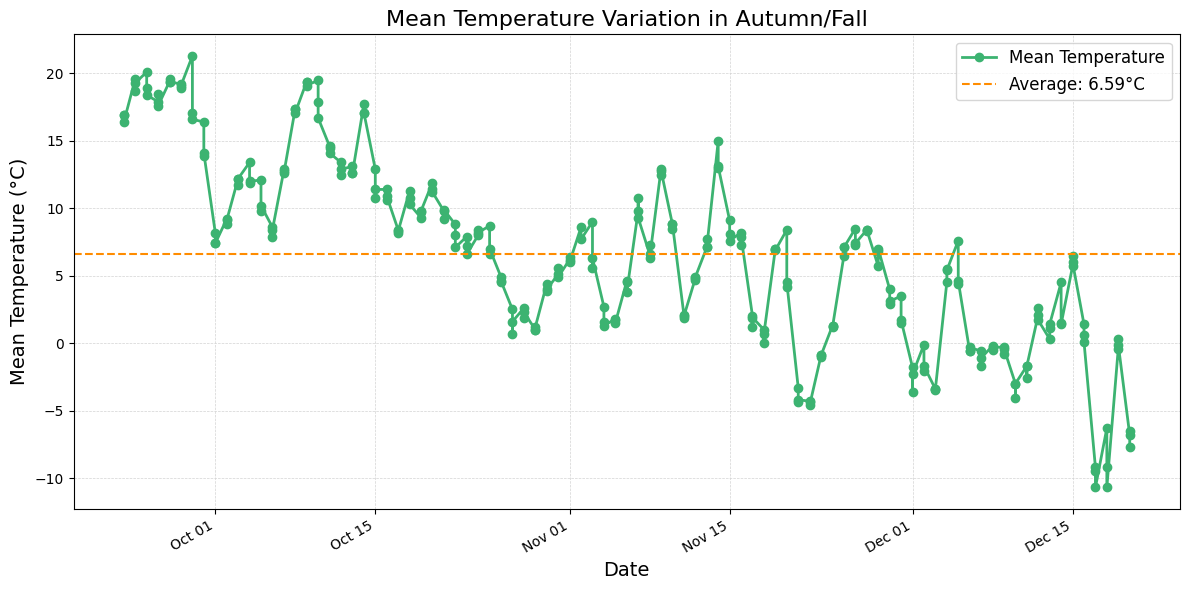

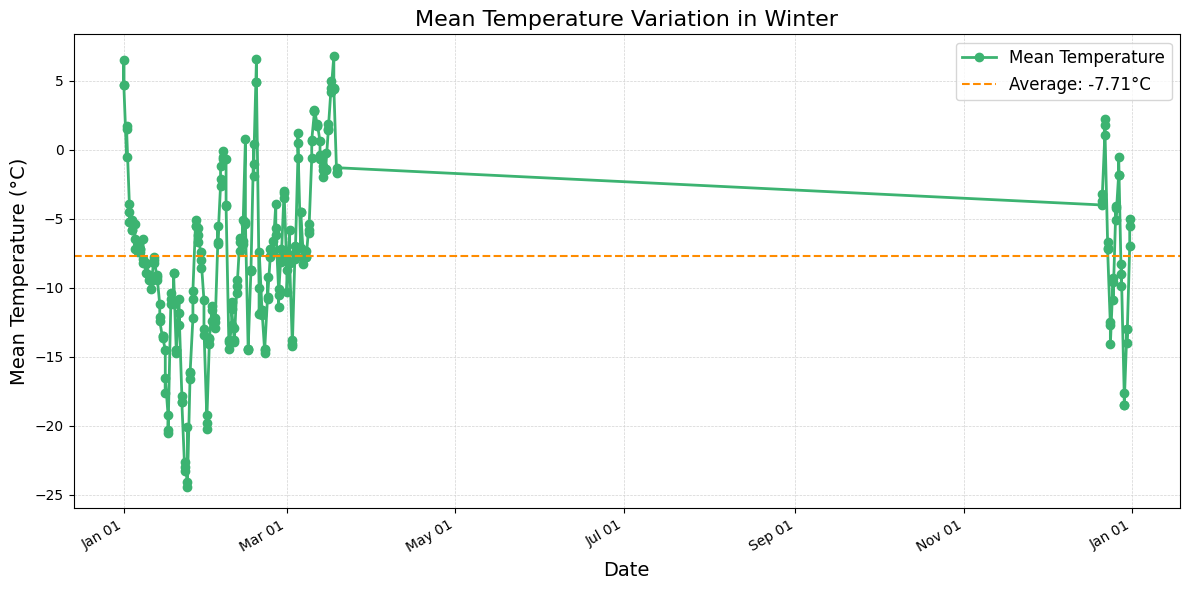

In [24]:
seasons = { # Defining season boundaries
    'Spring': {'start': '03-20', 'end': '06-20'},
    'Summer': {'start': '06-21', 'end': '09-22'},
    'Autumn/Fall': {'start': '09-23', 'end': '12-20'},
    'Winter': {'start': '12-21', 'end': '03-19'}
}

year = 2011 # Setting the year
for season, bounds in seasons.items(): # Filter and plot data for each season
    season_data = filter_season_data(properties_list, bounds['start'], bounds['end'], year)
    plot_season_temperature_variation(season_data, season)

# Convert to HTML

Please ignore
This cell will convert the notebook to HTML

In [ ]:
%%shell
jupyter nbconvert --to html "/content/GGE6404Assignemnt2.ipynb"